## Analyseur de cellules de paludisme

Le paludisme pèse lourdement sur la santé humaine et impose un lourd fardeau social et économique dans les pays à revenu faible et intermédiaire, en particulier en Afrique subsaharienne et en Asie du Sud. Environ 219 millions de personnes ont souffert de la maladie en 2017 et environ 435000 sont décédées. Plus de 90% des décès ont eu lieu en Afrique et plus de 60% concernaient des enfants de moins de 5 ans.

<hr>

## Introduction

Le but de ce noyau est de construire un modèle capable de détecter les parasites du paludisme dans une image cellulaire. Le modèle analysera une image segmentée des globules rouges et la classera comme «non infectée» ou «parasitée». Une fois formé, le modèle sera déployé en ligne en tant qu'application Web Tensorflow.js.

Le diagnostic du paludisme est actuellement un processus manuel. Cette application prototype est capable d'analyser automatiquement par lots des images de cellules. Par conséquent, cela peut aider à accélérer le flux de travail de diagnostic d'un médecin et à réduire les erreurs de diagnostic. Il peut également aider le personnel médical à trier les patients en leur permettant d'évaluer rapidement la gravité de l'infection de chaque patient.

Nous allons faire de l'EDA de base, construire un modèle Keras cnn, faire une validation croisée en 5 fois, entraîner le modèle en utilisant toutes les données et enfin évaluer le modèle sur un ensemble d'exclusion.


## Contents

<a href='#Connaissance du domaine'>1. Domain Knowledge</a><br>
<a href='#EDA'>2. EDA</a><br>
<a href='#
20/5000
Créer un ensemble d exclusion'>3. Create a Holdout Set</a><br>
<a href='#Train-Test-Split_Model'>4. Train-Test-Split Model</a><br>
<a href='#Error_Analysis'>5. Error Analysis</a><br>
<a href='#Cross_Validation'>6. 5 Fold Cross Validation</a><br>
<a href='#Train'>7. Train the Final Model on all data</a><br>
<a href='#Evaluate'>8. Evaluate the Final Model on the Holdout Set</a><br>
<a href='#Convert'>9. Convert the Final Model to Tensorflow.js</a><br>

<a href='#Citations'>Citations</a><br>
<a href='#Reference_Kernels'>Reference Kernels</a><br>
<a href='#Helpful_Resources'>Helpful Resources</a><br>
<a href='#Conclusion'>Conclusion</a><br>


In [15]:
#
# set seeds to ensure repeatability of results
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

import pandas as pd
import numpy as np
import os

import cv2
import tensorflow

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import itertools
import shutil
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy


# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [16]:
#
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

NUM_HOLDOUT_IMAGES = 200

NUM_EPOCHS = 10
NUM_FOLDS = 5

PADDING = 10
BATCH_SIZE = 10


NUM_FINAL_MODEL_EPOCHS = 10

| <a id='Domain_Knowledge'></a>

## 1. Connaissance du domaine




### Faits rapides

- Le paludisme est une maladie qui infecte et détruit les globules rouges.
- Les médecins analysent des frottis sanguins épais et minces pour diagnostiquer le paludisme et déterminer sa gravité.
- Le parasite responsable du paludisme s'appelle Plasmodium.
- Le moustique femelle Anopheles est le seul moustique qui transmet le paludisme.


### Background

L'examen microscopique de frottis sanguins épais et minces est le test le plus simple et le plus fiable pour le paludisme. Les frottis sanguins sont souvent prélevés sur une piqûre de doigt.

<br>

<img src="https://xrayspoumon.go.yj.fr/assets/glassslide.jpg" width="400"></img>

<h5 align="center">Fig 1. Microscope and glass slide</h5>

<br>
<br>

<img src="https://xrayspoumon.go.yj.fr/assets/raw_image.jpg" width="400"></img>

<h5 align="center">Fig 2. Cells seen under a microscope. <br>
Thin blood smear.</h5>

<br
    
<br>

<img src="https://xrayspoumon.go.yj.fr/assets/parasitized.png" width="200"></img>

<h5 align="center">Fig 3. Segmented parasitized cell</h5>

<br>
<br>

* Le diagnostic du paludisme comprend les éléments suivants *: <br>
> - Déterminer si le parasite du paludisme est présent.
> - Déterminer les espèces de parasites.
> - Déterminer la densité parasitaire en comptant le nombre de cellules infectées.
<br>

* Frottis de sang épais * <br>

Un frottis de sang épais est une goutte de sang sur une lame de verre. Il est utilisé pour déterminer s'il y a des parasites dans le sang. C'est un échantillon de sang plus grand car il ne peut y avoir que quelques parasites présents, donc un échantillon plus grand est nécessaire pour les détecter. Si aucun parasite n'est détecté, le patient subira des frottis sanguins répétés toutes les 8 heures pendant quelques jours pour confirmer qu'il n'y a pas d'infection palustre.

<br>

* Frottis de sang mince * <br>

Un frottis de sang mince est une goutte de sang qui se répand sur une grande surface de la lame de verre. Ce frottis sanguin aide le médecin à découvrir quelle espèce de parasite est à l'origine de l'infection.

<br>

* Plasmodium * <br>

C'est le parasite qui cause le paludisme. Il existe de nombreuses espèces de Plasmodium. Cinq espèces causent le paludisme - P. vivax, P. ovale, P. malariae, P. knowlesi et P. falciparum. La plupart des décès sont causés par P. falciparum. Les autres espèces provoquent généralement une forme plus bénigne de paludisme.

<br>

* Parasitémie * <br>

Il s'agit du pourcentage de globules rouges infectés par le paludisme (densité parasitaire). Ceci est calculé en comptant le nombre de cellules infectées visibles au microscope. Ce nombre aide les médecins à déterminer la gravité de la maladie. Ils prescrivent ensuite un traitement en fonction de la gravité. Par exemple, si un pourcentage élevé de cellules sanguines est infecté, le médicament peut être administré directement dans une veine plutôt que par voie orale.

<br>


| <a id='EDA'></a>

## 2. EDA

### Combien de fichiers y a-t-il dans chaque dossier?

In [17]:
#
path_uninfected = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Uninfected'
path_parasitized = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Parasitized'

uninfected_list = os.listdir(path_uninfected)
parasitized_list = os.listdir(path_parasitized)

print('Uninfected: ', len(uninfected_list))
print('Parasitized: ', len(parasitized_list))

Uninfected:  13780
Parasitized:  13780


La description des données indique qu'il devrait y avoir 27558 images de cellules, soit 13779 fichiers par dossier. Nous voyons que chaque dossier a un fichier supplémentaire. Plus tard, nous vérifierons de quel type de fichier il s'agit.

### Jetons un coup d'œil à quelques images de chaque classe

Il y a deux classes
- non infecté
- parasité.

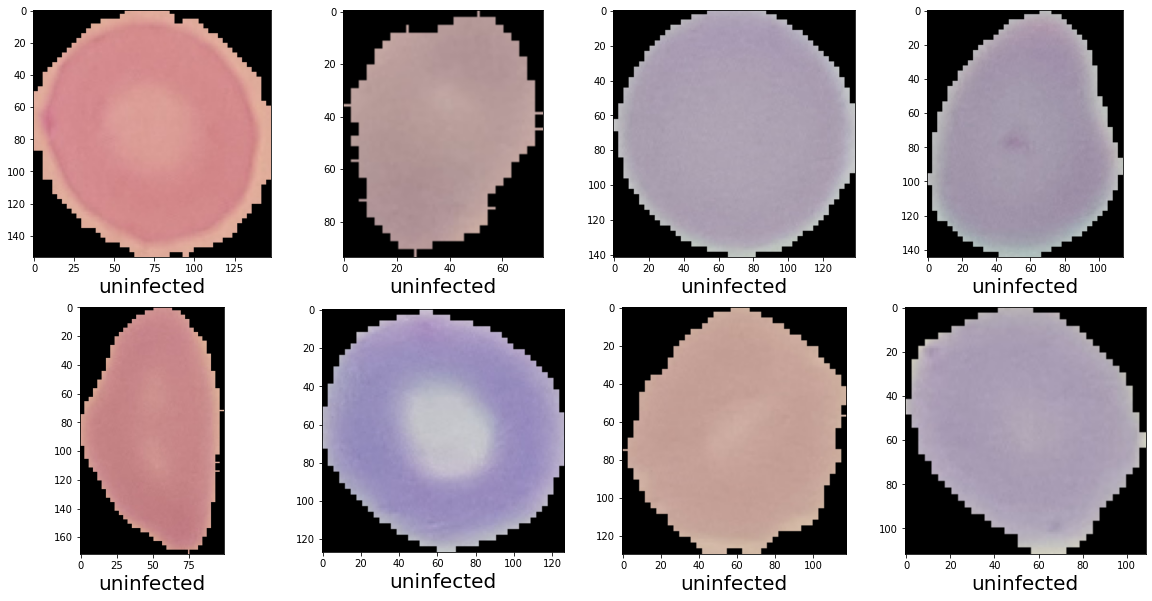

In [18]:
#
path_uninfected = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Uninfected/'
path_parasitized = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image = uninfected_list[i]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('uninfected', fontsize=20)

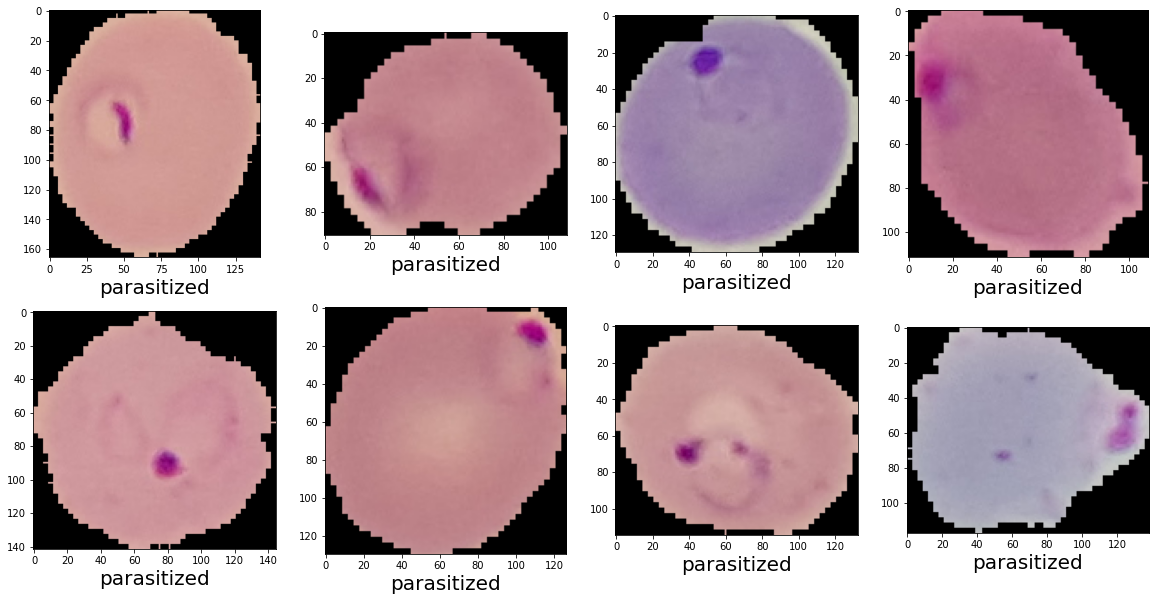

In [19]:
#
path_uninfected = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/Uninfected/'
path_parasitized = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image = parasitized_list[i]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.xlabel('parasitized', fontsize=20)

### Vérifiez si des fichiers non image se trouvent dans les dossiers

Nous voyons qu'il y a en fait 13780 fichiers dans chaque dossier et non 13779 comme prévu. Les dossiers peuvent parfois contenir des fichiers créés automatiquement lors du traitement. Ces fichiers peuvent provoquer des erreurs dans le code si nous ne savons pas qu'ils existent - comme le code que nous avons écrit ci-dessus pour afficher les images. Vérifions s'il y a des fichiers non image dans les dossiers. 

In [20]:
#
# Check if any non image files are present in the folder

# sample image name: C140P101ThinF_IMG_20151005_211735_cell_159.png

for item in uninfected_list:
    # split the filename into a list
    file_list = item.split('.')
    
    # check if the file extension is not png
    if file_list[1] != 'png':
        print('Uninfected folder: ', item)

Uninfected folder:  Thumbs.db


In [21]:
#
# Check if any non image files are present in the folder

for item in parasitized_list:
    # split the filename into a list
    file_list = item.split('.')
    
    # check if the file extension is not png
    if file_list[1] != 'png':
        print('Parasitized folder: ',item)

Parasitized folder:  Thumbs.db


Nous voyons que chaque dossier a un fichier non image appelé Thumbs.db. Maintenant que nous savons que ces fichiers non image existent, nous serons sûrs de les exclure plus tard.

### Mettre les noms d'images dans des dataframes

Ici, nous allons créer un dataframe appelé df_combined qui comprend à la fois des images non infectées et parasitées. Ce nouveau dataframe aura une colonne montrant la classe cible de chaque image.

In [22]:
#
# create the dataframe
df_uninfected = pd.DataFrame(uninfected_list, columns=['image_id'])

# remove the non image file
df_uninfected = df_uninfected[df_uninfected['image_id'] != 'Thumbs.db']

# add a target column
df_uninfected['target'] = 0


# create the dataframe
df_parasitized = pd.DataFrame(parasitized_list, columns=['image_id'])

# remove the non image file
df_parasitized = df_parasitized[df_parasitized['image_id'] != 'Thumbs.db']

# add a target column
df_parasitized['target'] = 1

#print(df_uninfected.shape)
#print(df_parasitized.shape)

# Combine the two dataframes

df_combined = pd.concat([df_uninfected, df_parasitized], axis=0).reset_index(drop=True)

#df_combined.shape

In [23]:
df_combined.head()

,image_id,target
0,C101P62ThinF_IMG_20150918_151942_cell_28.png,0
1,C37BP2_thinF_IMG_20150620_133001a_cell_67.png,0
2,C51AP12thinF_IMG_20150724_162636_cell_17.png,0
3,C211ThinF_IMG_20151029_164451_cell_34.png,0
4,C213ThinF_IMG_20151106_112252_cell_161.png,0


In [24]:
# Check the shape.
# There should be 27558 rows.

df_combined.shape

(27558, 2)

In [25]:
# Check if the image names are unique.
# The output should be 27558

df_combined['image_id'].nunique()

27558


La sortie ci-dessus correspond au nombre de lignes. Cela confirme que chaque image a un nom unique. Ceci est important à vérifier car les noms de fichiers image en double entraîneront des erreurs dans le code de traitement que nous écrirons plus tard.

### Quelles sont les tailles d'image et combien de canaux ont chacune?

Ici, nous ajouterons les informations suivantes sur chaque image au dataframe df_combined:

w = width<br>
h = height<br>
c = number of channels<br>
max_pixel_value<br>
min_pixel_value<br>
image_format

In [26]:
#
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    
    path_uninfected = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Uninfected/'
    path_parasitized = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Parasitized/'
     
    if file_name in uninfected_list:
        
        path = path_uninfected
        
    else:
        path = path_parasitized
    
    
    image = cv2.imread(path + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    img_format = file_name.split('.')[1]
    output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val, img_format]
    return output

m = np.stack(df_combined['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val', 'image_format'])

df_combined = pd.concat([df_combined,df],axis=1, sort=False)

df_combined.head(10)

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
0,C101P62ThinF_IMG_20150918_151942_cell_28.png,0,130,130,3,221,0,png
1,C37BP2_thinF_IMG_20150620_133001a_cell_67.png,0,154,148,3,231,0,png
2,C51AP12thinF_IMG_20150724_162636_cell_17.png,0,94,76,3,205,0,png
3,C211ThinF_IMG_20151029_164451_cell_34.png,0,142,139,3,205,0,png
4,C213ThinF_IMG_20151106_112252_cell_161.png,0,145,115,3,199,0,png
5,C72P33_ThinF_IMG_20150815_104045_cell_163.png,0,172,100,3,227,0,png
6,C189P150ThinF_IMG_20151203_140902_cell_25.png,0,127,127,3,212,0,png
7,C97P58ThinF_IMG_20150917_151512_cell_16.png,0,130,118,3,214,0,png
8,C169P130ThinF_IMG_20151118_172913_cell_160.png,0,112,109,3,213,0,png
9,C230ThinF_IMG_20151112_150329_cell_255.png,0,124,124,3,203,0,png


In [27]:
# Check if all images have 3 channels
df_combined['c'].value_counts()

3    27558
Name: c, dtype: int64

In [28]:
# Check if all images are in png format
df_combined['image_format'].value_counts()

png    27558
Name: image_format, dtype: int64

In [29]:
# Check for all black images
len(df_combined[(df_combined['max_pixel_val'] == 0) & (df_combined['max_pixel_val'] == 0)])

0

In [30]:
# Check for all white images
len(df_combined[(df_combined['max_pixel_val'] == 255) & (df_combined['max_pixel_val'] == 255)])

0

### Afficher des images aléatoires de chacune des classes cibles

Les images sont sélectionnées au hasard. Par conséquent, différentes images seront affichées chaque fois que le code est exécuté. Vous verrez également que les images parasitées semblent avoir une zone bleue qui n'est pas aussi courante dans les images non infectées.

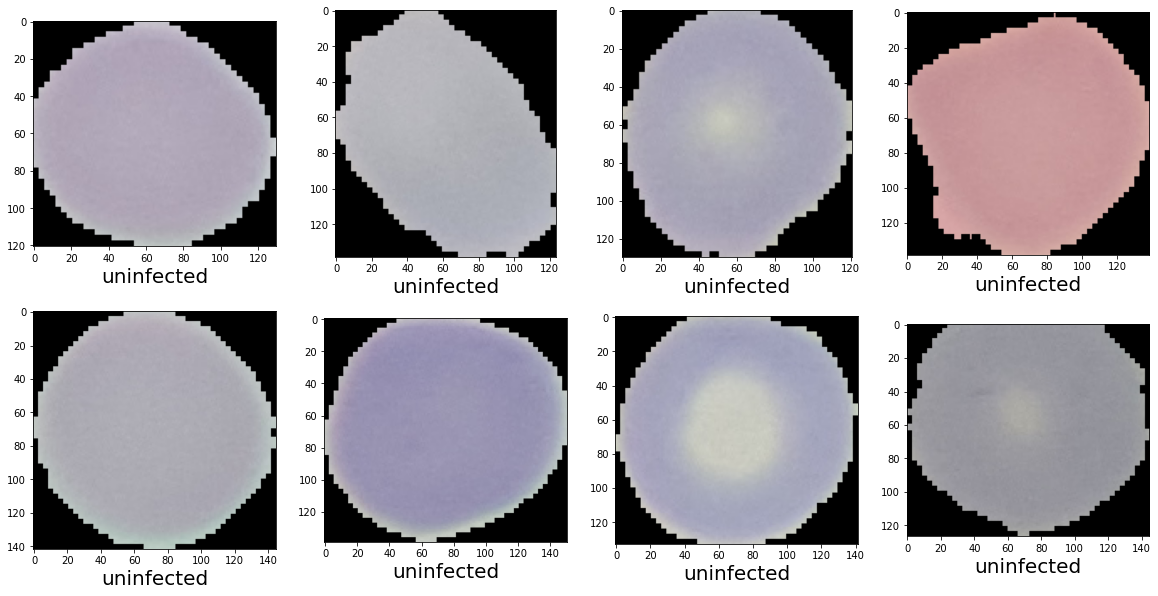

In [31]:
#
path_uninfected = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Uninfected/'
path_parasitized = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_uninfected['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('uninfected', fontsize=20)
    


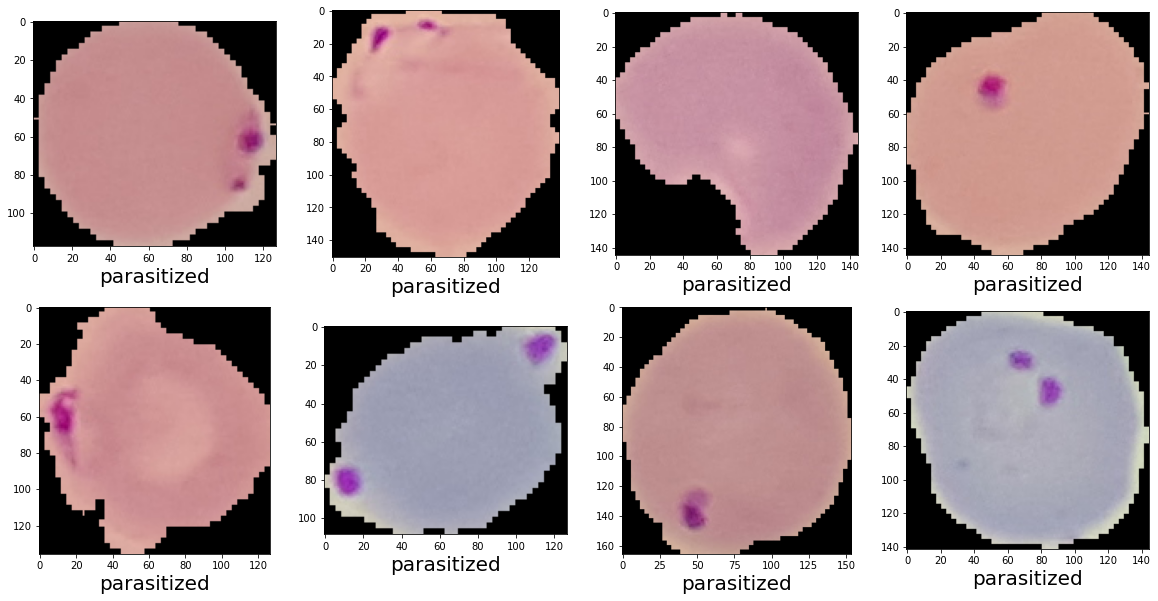

In [32]:
#
path_uninfected = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Uninfected/'
path_parasitized = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_parasitized['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.xlabel('parasitized', fontsize=20)

### EDA Summary

- Il y a 27 558 images de cellules segmentées.
- Chaque dossier contient 13 779 images.
- Les images sont de différentes tailles.
- Toutes les images sont au format png.
- Toutes les images ont 3 canaux, c'est-à-dire que toutes sont des images en couleur.
- Il n'y a pas d'images entièrement noires ou blanches.
- La distribution cible est équilibrée, c'est-à-dire que chaque classe cible a le même nombre d'images.
- Toutes les cellules ont été segmentées à partir de fines lames de frottis sanguins.
- L'espèce parasite sur toutes les images parasitées est P. falciparum.
- Chaque dossier contient un fichier non image appelé Thumbs.db.
- La présence d'une zone bleuâtre à l'intérieur de la cellule semble être un indicateur courant (mais non définitif) qu'une cellule est parasitée.



| <a id='Create_a_Holdout-Set'></a>

## 3. Create a Holdout Set


Au fur et à mesure que nous continuons à nous entraîner, à valider et à modifier un modèle, nous pourrions au fil du temps commencer à surajuster les données de validation sans nous en rendre compte. Cela signifie que le modèle fonctionnera bien pendant l'entraînement, mais qu'il fonctionnera mal sur des données invisibles, c'est-à-dire que l'application fonctionnera mal en production.

Ici, nous allons créer un ensemble d'exclusion contenant 200 images. Nous garderons cette retenue de côté et ne l'utiliserons qu'à la fin pour vérifier comment le modèle final fonctionne sur des données invisibles.

In [33]:
#
# shuffle
df_combined = shuffle(df_combined, random_state=101)

# create a holdout set with 200 samples
df_holdout = df_combined.sample(NUM_HOLDOUT_IMAGES, random_state=101)

# create a list of holdout images
holdout_images_list = list(df_holdout['image_id'])


# Select only rows that are not part of the holdout set.
# Note the use of ~ to execute 'not in'.
df_data = df_combined[~df_combined['image_id'].isin(holdout_images_list)]


In [34]:
df_holdout.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
12152,C209ThinF_IMG_20151029_160857_cell_235.png,0,121,100,3,207,0,png
24272,C152P113ThinF_IMG_20151115_124557_cell_174.png,1,109,115,3,216,0,png
16731,C119P80ThinF_IMG_20151002_124425_cell_145.png,1,154,139,3,230,0,png
22176,C175P136NThinF_IMG_20151127_141428_cell_232.png,1,175,160,3,214,0,png
25394,C80P41ThinF_IMG_20150817_111246_cell_118.png,1,124,130,3,228,0,png


In [35]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
13545,C168P129ThinF_IMG_20151118_153739_cell_48.png,0,139,142,3,203,0,png
17649,C133P94ThinF_IMG_20151004_154512_cell_132.png,1,136,112,3,220,0,png
19081,C181P142ThinF_IMG_20151127_160514_cell_173.png,1,121,124,3,213,0,png
17511,C182P143NThinF_IMG_20151201_171950_cell_200.png,1,115,112,3,197,0,png
21254,C118P79ThinF_IMG_20151002_110942_cell_5.png,1,157,136,3,237,0,png


In [36]:
# Check the shapes.
# The ouput should be:
# (200, 8)
# (27358, 8)

print(df_holdout.shape)
print(df_data.shape)

(200, 8)
(27358, 8)


In [37]:
# Check the target distribution in the holdout set.
# 0 = uninfected
# 1 = parasitized

df_holdout['target'].value_counts()

1    104
0     96
Name: target, dtype: int64

Nous avons maintenant un ensemble d'exclusion contenant 200 images.

| <a id='Train-Test-Split_Model'></a>

## 4. Train-Test-Split Model

Le partage des essais par train n'est pas le moyen idéal pour évaluer la performance du modèle. Cependant, c'est un bon point de départ car il est simple à configurer et s'exécute 5 fois plus vite que la validation croisée 5 fois. Cela nous aide à:

- Ayez rapidement une idée du type de performance que nous pouvons attendre de ces données.
- Testez rapidement différentes architectures et paramètres.
- Établissez le flux de travail qui sera utilisé ultérieurement dans la validation croisée.
- Vérifiez les courbes d'entraînement pour voir si le modèle est surajusté.
- Vérifiez les courbes d'apprentissage pour établir le nombre d'époques que nous utiliserons lors de l'apprentissage du modèle final sur toutes les données.
- Effectuer une analyse des erreurs.

Un modèle de train-test-split est un guide approximatif. Pour décider si un changement particulier a réellement amélioré les performances du modèle, nous baserons cette décision sur les résultats de la validation croisée. C'est important. Si nous n'utilisons pas la validation croisée, nous pouvons penser que nous nous améliorons mais en réalité, nous n'allons peut-être nulle part.

### Create a Directory Structure

Pour réduire l'utilisation de la RAM et empêcher ce noyau de planter, nous alimenterons par lots les images lors de la formation du modèle. Nous utiliserons des générateurs pour ce faire. Pour utiliser cette approche, Keras nécessite la configuration d'une structure de répertoires particulière. Keras utilise cette structure pour déduire automatiquement la classe (cible) de chaque image.

In [38]:

base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # a_uninfected
    # b_parasitized

# val
    # a_uninfected
    # b_parasitized


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_uninfected = os.path.join(train_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(train_dir, 'b_parasitized')
os.mkdir(b_parasitized)


# create new folders inside val_dir
a_uninfected = os.path.join(val_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(val_dir, 'b_parasitized')
os.mkdir(b_parasitized)

In [39]:
# check if base_dir has been created
!ls

 assets					        final_model
 base_dir				        fonts
 C33P1thinF_IMG_20150619_114756a_cell_179.png   how_the_js_code_works.txt
 C33P1thinF_IMG_20150619_114756a_cell_180.png   images
 C33P1thinF_IMG_20150619_114756a_cell_181.png   index.html
 C33P1thinF_IMG_20150619_114756a_cell_182.png   js
 C33P1thinF_IMG_20150619_115740a_cell_161.png   jscript
 C33P1thinF_IMG_20150619_115808a_cell_205.png  'Malaria Cell Analyzer.ipynb'
 cell_images				        README.md
 css


In [40]:
# see what's inside base_dir
os.listdir('base_dir')

['train_dir', 'val_dir']

### Create the Train and Val Sets
Nous allons créer un ensemble de valeurs stratifiées. Cela signifie que l'ensemble de valeurs aura la même distribution cible que l'ensemble de trains. En fait, la stratification n'est pas essentielle ici car la cible est équilibrée. Pour cette raison, il y a de fortes chances que la sélection aléatoire de lignes donne toujours à l'ensemble de valeurs une distribution cible assez équilibrée. La stratification est plus applicable pour les données où la cible est déséquilibrée.

In [41]:
# select the column that we will use for stratification
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(23254, 8)
(4104, 8)


In [42]:
# Check the target distribution of the val set.
# The target should be approx balanced.

df_val['target'].value_counts()

0    2053
1    2051
Name: target, dtype: int64

### Transfer the images into the folders

In [43]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [44]:
df_data.head()

,target,w,h,c,max_pixel_val,min_pixel_val,image_format
image_id,,,,,,,
C168P129ThinF_IMG_20151118_153739_cell_48.png,0,139,142,3,203,0,png
C133P94ThinF_IMG_20151004_154512_cell_132.png,1,136,112,3,220,0,png
C181P142ThinF_IMG_20151127_160514_cell_173.png,1,121,124,3,213,0,png
C182P143NThinF_IMG_20151201_171950_cell_200.png,1,115,112,3,197,0,png
C118P79ThinF_IMG_20151002_110942_cell_5.png,1,157,136,3,237,0,png


In [45]:
#
path_uninfected = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Uninfected'
path_parasitized = '/home/hindka/Bureau/Malaria-Cell-Analyzer-master/cell_images/cell_images/Parasitized'

# Get a list of images in each of the two folders
folder_1 = os.listdir(path_uninfected)
folder_2 = os.listdir(path_parasitized)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    target = df_data.loc[image,'target']
    
    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)
        
    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)
        


# Transfer the val images

for image in val_list:
    
    fname = image
    target = df_data.loc[image,'target']
    
    
    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'
        
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

        
    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [46]:
# Print the number of images in each folder

# train
print(len(os.listdir('base_dir/train_dir/a_uninfected')))
print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

# val
print(len(os.listdir('base_dir/val_dir/a_uninfected')))
print(len(os.listdir('base_dir/val_dir/b_parasitized/')))

11630
11624
2053
2051


### Set Up the Generators

In [47]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [48]:
# Note that here we are normalizing the images inside the generator.
# If you wanted to add some data augmentation you could do it here.
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 23254 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.


### Create the Model Architecture

I found this cnn architecture a while ago in a kernel created by @fmarazzi. I've since used this on several projects. It really is a good multi-purpose architecture. Here I've modified it slightly by adding a ZeroPadding layer. Later, in the error analysis section, I'll explain why I added this layer.

In [49]:
# source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))

model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 114, 114, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 64)        1

### Train the Model

Please note that we've set the learning rate to reduce (decay) at each epoch.

In [50]:
model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
                              
                              
callbacks_list = [checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=NUM_EPOCHS, verbose=1,
                           callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
2326/2326 [==============================] - 5962s 3s/step - loss: 0.3531 - accuracy: 0.8083 - val_loss: 0.1691 - val_accuracy: 0.9454
Epoch 2/10
2326/2326 [==============================] - 4137s 2s/step - loss: 0.1480 - accuracy: 0.9538 - val_loss: 0.1529 - val_accuracy: 0.9496
Epoch 3/10
2326/2326 [==============================] - 5411s 2s/step - loss: 0.1356 - accuracy: 0.9567 - val_loss: 0.1488 - val_accuracy: 0.9537
Epoch 4/10
2326/2326 [==============================] - 5648s 2s/step - loss: 0.1290 - accuracy: 0.9591 - val_loss: 0.1444 - val_accuracy: 0.9510
Epoch 5/10
2326/2326 [==============================] - 5906s 3s/step - loss: 0.1218 - accuracy: 0.9604 - val_loss: 0.1447 - val_accuracy: 0.9508
Epoch 6/10
2326/2326 [==============================] - 5570s 2s/step - loss: 0.1160 - accuracy: 0.9624 - val_loss: 0.1376 - val_accuracy: 0.9552
Epoch 7/10
1010/2326 [============>.............

### Evaluate the model using the val set

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

### Plot the Training Curves

In [ ]:
#
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Create a Confusion Matrix

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

In [ ]:
# Print the label associated with each class
test_gen.class_indices

In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

In [ ]:
# If you wanted to get the image_id's to match them to predictions this
# is how to do it.

# test_gen.filenames

In [ ]:
# check the number of predictions
predictions.shape

In [ ]:
#
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_gen.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['uninfected', 'parasitized']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report¶

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [ ]:
# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.<br>

| <a id='Error_Analysis'></a>

## 5. Error Analysis

Dans cette section, nous n'utiliserons aucune gymnastique statistique sophistiquée. Nous allons simplement regarder les images que le modèle a correctement prédites et celles qu'il s'est trompées. Nous voulons voir s'il existe des modèles ou des problèmes qui auraient pu entraîner des erreurs dans le modèle.

Placez le val image_id, les étiquettes et les prédictions dans un dataframe.Put the val image_id, labels and predictions into a dataframe.

In [ ]:
#
# put the val image_id, labels and predictions into a dataframe

val_pred_dict = {
    'image_id': test_gen.filenames,
    'val_labels': test_gen.classes,
    'val_preds': predictions.argmax(axis=1)
}

df_val_preds = pd.DataFrame(val_pred_dict)


# Adjust the file names

# sample image name: a_uninfected/C100P61ThinF_IMG_20150918_144104_...
# we want just this part: C100P61ThinF_IMG_20150918_144104_...

def adjust_file_names(x):
    # split into a list based on '/'
    fname = x.split('/')
    # chose the second item in the list which is the image name
    fname = fname[1]
    
    return fname

df_val_preds['image_id'] = df_val_preds['image_id'].apply(adjust_file_names)


# savedf_val_preds so we can analyze the results later
pickle.dump(df_val_preds,open('df_val_preds.pickle','wb'))

# code to load the dataframe
# df_val_preds = pickle.load(open('df_val_preds','rb'))


#df_val_preds.head()

In [ ]:
df_val_preds.head()

In [ ]:
# filter out those rows where the model made correct predictions
df_correct = df_val_preds[df_val_preds['val_labels'] == df_val_preds['val_preds']]

# filter out those rows where the model made wrong predictions
df_wrong = df_val_preds[df_val_preds['val_labels'] != df_val_preds['val_preds']]

print(df_correct.shape)
print(df_wrong.shape)

### Analyze the correct predictions

In [ ]:
df_correct.head()

#### Display images that are parasitized that the model predicted correctly

In [ ]:
#
df_1 = df_correct[df_correct['val_labels'] == 1]

# we see diffrent images each time the code is run.

path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.tight_layout()
    
    plt.xlabel('true: 1, pred: 1', fontsize=20)

#### Display images that are uninfected that the model predicted correctly

In [ ]:
#
df_0 = df_correct[df_correct['val_labels'] == 0]

# we see diffrent images each time the code is run.

path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('true: 0, pred: 0', fontsize=20)
    

### Analyze the wrong predictions

#### Display images that are parasitized but the model predicted uninfected

In [ ]:
#
df_1 = df_wrong[df_wrong['val_labels'] == 1]


# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.tight_layout()
    
    plt.xlabel('true: 1, pred: 0', fontsize=20)
    


#### Display images that are uninfected but the model predicted parasitized

In [ ]:
#
df_0 = df_wrong[df_wrong['val_labels'] == 0]

# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('true: 0, pred: 1', fontsize=20)
    

### Observations et commentaires

Dans les cas où l'étiquette était parasitée mais que le modèle prédisait non infecté, j'ai remarqué que la zone bleue était située près du bord de l'image. Se pourrait-il que le modèle ne détecte pas de motifs importants situés au bord des images? Pour résoudre ce problème, j'ai décidé d'ajouter une couche de remplissage à l'architecture du modèle. Ce calque a ajouté un remplissage zéro de 10 pixels autour de chaque image. J'ai trouvé que les scores de validation croisée se sont améliorés après ce changement.


Lors de cette analyse des erreurs, nous partons du principe que s'il existe une discordance entre l'étiquette et la prédiction, le modèle a commis une erreur. Cependant, il existe une autre possibilité: la prédiction du modèle est correcte. Il y a 27 558 images dans ce jeu de données. Toutes les images ont été examinées et étiquetées par le même expert. Cela a dû être un processus fastidieux et long, il est donc possible que certaines images aient été mal étiquetées.

À ce stade, il serait utile de collaborer avec un expert du domaine afin de discuter des raisons possibles des erreurs commises par ce modèle. Sont-ils le résultat d'une faiblesse du modèle, d'étiquettes incorrectes ou peut-être d'images endommagées? L'étiquette correcte est-elle facile à classer pour un humain ou un humain aurait-il du mal à poser un diagnostic correct? Quels sont les principaux indicateurs recherchés par un expert lors de l'examen des images cellulaires? Le modèle voit-il des choses qu'un expert n'a pas remarquées?

| <a id='Cross_Validation'></a>

## 5 Fold Cross Validation

Ici, nous allons simplement appliquer le même flux de travail que celui que nous avons utilisé pour le modèle train-test-split à 5 fois. Pour chaque pli, nous aurons la perte, la précision et l'auc. Ensuite, nous ferons la moyenne des résultats des 5 plis pour obtenir les scores finaux.

In [ ]:
#
# ==============================
# Create the 5 Folds
# ==============================

# shuffle df_combined and change the name to df_data
df_data = shuffle(df_combined.copy())

# train_test_split
y = df_data['target']

# initialize kfold
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=101)

# define y for stratification
y = df_data['target']

# Note:
# Each fold is a tuple ([train_index_values], [val_index_values])
# fold_0, fold_1, fold_2, fold_3, fold_5 = kf.split(df_train, y)

# Put the folds into a list. This is a list of tuples.
# y was set above.
fold_list = list(kf.split(df_data, y))


# ==============================
# Loop Through the Folds
# ==============================

# create a list to store the predictions
val_pred_list = []

# create a list to store the scores
val_acc_list = []
val_loss_list = []
val_auc_list = []


for i, fold in enumerate(fold_list):

    # Delete the image data directory we created to prevent a Kaggle error.
    # Kaggle allows a max of 500 files to be saved.
    
    if os.path.isdir('base_dir') == True: # return true if the directory exists
    
        shutil.rmtree('base_dir')
        
        
    
    # set df_data
    df_data = df_combined.copy()
    
    print('=== Fold_' + str(i) + ' ===')
    print('\n')

    # map the train and val index values to dataframe rows
    df_train = df_data[df_data.index.isin(fold[0])]
    df_val = df_data[df_data.index.isin(fold[1])]
    



    # ==============================
    # Create a Directory Structure
    # ==============================

    # Create a new directory
    base_dir = 'base_dir'
    os.mkdir(base_dir)


    #[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

    # now we create 2 folders inside 'base_dir':

    # train
        # a_uninfected
        # b_parasitized

    # val
        # a_uninfected
        # b_parasitized


    # create a path to 'base_dir' to which we will join the names of the new folders
    # train_dir
    train_dir = os.path.join(base_dir, 'train_dir')
    os.mkdir(train_dir)

    # val_dir
    val_dir = os.path.join(base_dir, 'val_dir')
    os.mkdir(val_dir)


    # [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
    # Inside each folder we create seperate folders for each class

    # create new folders inside train_dir
    a_uninfected = os.path.join(train_dir, 'a_uninfected')
    os.mkdir(a_uninfected)
    b_parasitized = os.path.join(train_dir, 'b_parasitized')
    os.mkdir(b_parasitized)


    # create new folders inside val_dir
    a_uninfected = os.path.join(val_dir, 'a_uninfected')
    os.mkdir(a_uninfected)
    b_parasitized = os.path.join(val_dir, 'b_parasitized')
    os.mkdir(b_parasitized)



    # =================================
    # Transfer the Images into Folders
    # =================================

    # Set the image_id as the index in df_data
    df_data.set_index('image_id', inplace=True)

    # Get a list of images in each of the two folders

    path_uninfected = '../input/cell_images/cell_images/Uninfected'
    path_parasitized = '../input/cell_images/cell_images/Parasitized'

    folder_1 = os.listdir(path_uninfected)
    folder_2 = os.listdir(path_parasitized)

    # Get a list of train and val images
    train_list = list(df_train['image_id'])
    val_list = list(df_val['image_id'])



    # Transfer the train images

    for image in train_list:

        fname = image
        target = df_data.loc[image,'target']

        if target == 0:
            label = 'a_uninfected'
        else:
            label = 'b_parasitized'

        if fname in folder_1:
            # source path to image
            src = os.path.join(path_uninfected, fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)
            #shutil.copyfile(src, dst)

        if fname in folder_2:
            # source path to image
            src = os.path.join(path_parasitized, fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)

            # copy the image from the source to the destination
            #shutil.copyfile(src, dst)



    # Transfer the val images

    for image in val_list:

        fname = image
        target = df_data.loc[image,'target']


        if target == 0:
            label = 'a_uninfected'
        else:
            label = 'b_parasitized'


        if fname in folder_1:
            # source path to image
            src = os.path.join(path_uninfected, fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)

            # copy the image from the source to the destination
            #shutil.copyfile(src, dst)

        if fname in folder_2:
            # source path to image
            src = os.path.join(path_parasitized, fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)

            # copy the image from the source to the destination
            #shutil.copyfile(src, dst)

    # Print the number of images in each folder

    # train
    #print(len(os.listdir('base_dir/train_dir/a_uninfected')))
    #print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

    # val
    #print(len(os.listdir('base_dir/val_dir/a_uninfected')))
    #print(len(os.listdir('base_dir/val_dir/b_parasitized/')))
    #print('\n')


    # ==============================
    # Set Up the Generators
    # ==============================

    train_path = 'base_dir/train_dir'
    valid_path = 'base_dir/val_dir'

    num_train_samples = len(df_train)
    num_val_samples = len(df_val)
    train_batch_size = BATCH_SIZE
    val_batch_size = BATCH_SIZE


    train_steps = np.ceil(num_train_samples / train_batch_size)
    val_steps = np.ceil(num_val_samples / val_batch_size)


    datagen = ImageDataGenerator(rescale=1.0/255)

    train_gen = datagen.flow_from_directory(train_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=train_batch_size,
                                            class_mode='categorical')

    val_gen = datagen.flow_from_directory(valid_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=val_batch_size,
                                            class_mode='categorical')

    # Note: shuffle=False causes the test dataset to not be shuffled
    test_gen = datagen.flow_from_directory(valid_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=val_batch_size,
                                            class_mode='categorical',
                                            shuffle=False)
    
    print('\n')

    # ==============================
    # Set Up the Model Architecture
    # ==============================



    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.3


    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                     input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))
    
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(2, activation = "softmax"))

    #model.summary()



    # ==============================
    # Train the Model
    # ==============================


    model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
                  metrics=['accuracy'])

    filepath = "model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                                 save_best_only=True, mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                       verbose=1, mode='max', min_lr=0.00001)


    callbacks_list = [checkpoint, reduce_lr]

    history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                                validation_data=val_gen,
                                validation_steps=val_steps,
                                epochs=NUM_EPOCHS, verbose=1,
                               callbacks=callbacks_list)



    # ==================================
    # Evaluate the Model on the Val Set
    # ==================================

    model.load_weights('model.h5')

    val_loss, val_acc = \
    model.evaluate_generator(test_gen, 
                            steps=val_steps)
    
    # append the acc score val_scores_list
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    
    # ==================================
    # Calculate the AUC Score
    # ==================================

    test_labels = test_gen.classes

    # make a prediction
    predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)
    
    # append the predictions to a list
    val_pred_list.append(predictions)
    
    val_auc = roc_auc_score(test_labels, predictions.argmax(axis=1))
    
    val_auc_list.append(val_auc)
    
    
    
    # ==================================
    # Print the Fold Scores
    # ==================================
    
    
    #print('\n')
    #print('Fold_' + str(i) + ' scores:\n')
    #print('val_loss:', val_loss)
    #print('val_acc:', val_acc)
    #print('val_auc:', val_auc)
    #print('\n')

    
    
    
# Calc the average score over the 5 folds
avg_acc = sum(val_acc_list)/len(val_acc_list)
avg_loss = sum(val_loss_list)/len(val_loss_list)
avg_auc = sum(val_auc_list)/len(val_auc_list)

#print('\n')
#print('Average for of all 5 folds:\n')
#print('Average Accuracy: ', avg_acc)
#print('Average Loss: ', avg_loss)
#print('Average AUC: ', avg_auc)

### Print the scores for each fold and the average scores

In [ ]:
#
# Print the scores

print('Val Acc')
for item in val_acc_list:
    print(item)
    
print('\n')

print('Val Loss')
for item in val_loss_list:
    print(item)
    
print('\n')

print('Val AUC')
for item in val_auc_list:
    print(item)

    
    
# Calc the average score over the 5 folds
avg_acc = sum(val_acc_list)/len(val_acc_list)
avg_loss = sum(val_loss_list)/len(val_loss_list)
avg_auc = sum(val_auc_list)/len(val_auc_list)

print('\n')
print('Average for of all 5 folds:\n')
print('Average Accuracy: ', avg_acc)
print('Average Loss: ', avg_loss)
print('Average AUC: ', avg_auc)

| <a id='Train'></a>

## 7. Train the Final Model using all the data

Nous n'utilisons pas de données de validation dans ce modèle final. Par conséquent, nous ne pourrons pas configurer le modèle pour enregistrer la meilleure époque. Nous devrons déterminer le nombre d'époques d'entraînement avant de commencer.

Pour déterminer ce nombre, je regarderais normalement les courbes d'entraînement (voir le modèle train-test-split) et déterminerais l'époque à laquelle le modèle a commencé à se surajouter, c'est-à-dire que les courbes de précision d'entraînement et de validation commencent à diverger. Cependant, avec ces données et cette architecture, il apparaît que le surajustement n'est pas un problème énorme car les courbes d'apprentissage et de validation ne divergent pas de manière significative. Par conséquent, choisir 10 époques semble donner un bon équilibre entre le temps de formation et la qualité du modèle.

Il est également important de garder à l'esprit que nous pouvons nous entraîner sur toutes les données, car nous définissons le taux d'apprentissage pour qu'il décroît à chaque époque, c'est-à-dire que le taux d'apprentissage a été planifié. Si nous avions utilisé un taux d'apprentissage dynamique (par exemple, ReduceLROnPlateau), nous aurons besoin d'un moyen de reproduire les changements de taux d'apprentissage qui se sont produits automatiquement lors de la validation croisée 5 fois. Par conséquent, l'utilisation d'un taux d'apprentissage programmé simplifie les choses.

In [ ]:
#
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

if os.path.isdir('base_dir') == True: # return true if the directory exists
    
        shutil.rmtree('base_dir')



# ==============================
# Set df_train
# ==============================

# This variable was set above. Just setting it here again for clarity.
holdout_images_list = list(df_holdout['image_id'])

# Select only rows that are not part of the holdout set.
# Note the use of ~ to execute 'not in'.
df_data = df_combined[~df_combined['image_id'].isin(holdout_images_list)]

df_train = df_data.copy()
df_val = df_holdout.copy()



# ==============================
# Create a Directory Structure
# ==============================

# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # a_uninfected
    # b_parasitized

# val
    # a_uninfected
    # b_parasitized


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_uninfected = os.path.join(train_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(train_dir, 'b_parasitized')
os.mkdir(b_parasitized)


# create new folders inside val_dir
a_uninfected = os.path.join(val_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(val_dir, 'b_parasitized')
os.mkdir(b_parasitized)



# =================================
# Transfer the Images into Folders
# =================================

# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

# Set the image_id as the index in df_data
df_holdout.set_index('image_id', inplace=True)



# Get a list of images in each of the two folders

path_uninfected = '../input/cell_images/cell_images/Uninfected'
path_parasitized = '../input/cell_images/cell_images/Parasitized'

folder_1 = os.listdir(path_uninfected)
folder_2 = os.listdir(path_parasitized)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:

    fname = image
    target = df_data.loc[image,'target']

    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'

    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)



# Transfer the val images

for image in val_list:

    fname = image
    target = df_holdout.loc[image,'target']


    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'


    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

# Print the number of images in each folder

# train
#print(len(os.listdir('base_dir/train_dir/a_uninfected')))
#print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

# val
#print(len(os.listdir('base_dir/val_dir/a_uninfected')))
#print(len(os.listdir('base_dir/val_dir/b_parasitized/')))
#print('\n')


# ==============================
# Set Up the Generators
# ==============================

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')


# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

print('\n')

# ==============================
# Set Up the Model Architecture
# ==============================


kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))

model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

#model.summary()



# ==============================
# Train the Model
# ==============================


model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
              metrics=['accuracy'])

# we are saving the model based on training accuracy
filepath = "final_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, 
                             save_best_only=True, mode='max')


callbacks_list = [checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            epochs=NUM_FINAL_MODEL_EPOCHS, verbose=1,
                           callbacks=callbacks_list)


# ==================================
# Evaluate the Model on the Val Set
# ==================================

model.load_weights('final_model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=val_steps)


# ==================================
# Calculate the AUC Score
# ==================================

test_labels = test_gen.classes

# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)


val_auc = roc_auc_score(test_labels, predictions.argmax(axis=1))




# ==================================
# Print the Scores
# ==================================

#print('\n')
#print('Accuracy: ', val_acc)
#print('Loss: ', val_loss)
#print('AUC: ', val_auc)


| <a id='Evaluate'></a>

## 8. Evaluate the Final Model on the Holdout Set

In [ ]:
# ==================================
# Print the Scores
# ==================================

print('\n')
print('Accuracy: ', val_acc)
print('Loss: ', val_loss)
print('AUC: ', val_auc)

### Create a Confusion Matrix

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

test_gen.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['uninfected', 'parasitized']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)


# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.<br>


<hr>

Nous avons maintenant un modèle entraîné qui peut être intégré dans l'application Web. Les métriques que nous avons calculées avant tout semblent très bonnes, ce qui signifie que le modèle devrait bien fonctionner sur des données invisibles.

De plus, comme nous avons utilisé une architecture simple, la taille du modèle sera inférieure à 10 Mo. Cela signifie qu'il se téléchargera rapidement. Par conséquent, la page Web se chargera rapidement et l'expérience utilisateur globale sera bonne.

| <a id='Convert'></a>

## 9. Convert the final model from Keras to Tensorflow.js

This conversion needs to be done so that the model can be loaded into the web app.

In [ ]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

In [ ]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras final_model.h5 tfjs/model

In [ ]:
# check that the folder containing the tfjs model files has been created
!ls

In [ ]:
# check that the tfjs files exist
os.listdir('tfjs/model')

### Delete the images that were moved around

In [ ]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

if os.path.isdir('base_dir') == True: # return true if the directory exists
    
        shutil.rmtree('base_dir')